In [13]:
!pip install pandas numpy matplotlib seaborn yfinance transformers scikit-learn xgboost alpha_vantage torch torchvision torchaudio


clear_output()

In [16]:
from IPython.display import clear_output
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import pipeline

import warnings
warnings.filterwarnings('ignore')  # Turn off warnings globally

from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
from sklearn.metrics import classification_report, accuracy_score

from alpha_vantage.timeseries import TimeSeries




clear_output()

In [2]:
# Ignore pandas copy warnings 
pd.options.mode.chained_assignment = None 


# 📚 Step 1: Inspecting and Preparing Datasets (Tesla & Apple News)

In this section:
- We will load the Tesla and Apple news datasets.
- We will retain only the necessary columns: `date`, `title`, and `content`.
- We will inspect and clean the date columns.
- Finally, we will merge the two datasets into a unified format.


In [3]:
# Load datasets
tesla_df = pd.read_csv('tesla_news.csv')
apple_df = pd.read_csv('apple_news.csv')

# Display first few rows
print("Tesla Dataset Sample:")
display(tesla_df.head())

print("Apple Dataset Sample:")
display(apple_df.head())

# Show columns
print("Tesla Columns:", tesla_df.columns.tolist())
print("Apple Columns:", apple_df.columns.tolist())

# Select only required columns
tesla_df_reduced = tesla_df[['date', 'title', 'content']].copy()
apple_df_reduced = apple_df[['date', 'title', 'content']].copy()

# Add 'company' column
tesla_df_reduced['company'] = 'Tesla'
apple_df_reduced['company'] = 'Apple'

# Preview after reduction
print("\nTesla Reduced Sample:")
display(tesla_df_reduced.head())

print("\nApple Reduced Sample:")
display(apple_df_reduced.head())

Tesla Dataset Sample:


,Unnamed: 0,date,source,title,link,content
0,0,28 Apr 2022,"New York Times, Late Edition (East Coast)",How Tesla Stock Price Might Affect Markets: [B...,https://www.proquest.com/usnews/docview/265597...,"Tesla is highly traded, and Elon Musk's sale o..."
1,1,18 May 2022,Wall Street Journal (Online),Elon Musk Calls ESG 'An Outrageous Scam' After...,https://www.proquest.com/usnews/docview/266576...,\nTesla Inc. was recently dropped from an equi...
2,2,14 Nov 2022,Wall Street Journal (Online),Elon Musk's Control Over Tesla's Board in Focu...,https://www.proquest.com/usnews/docview/273573...,"\nWILMINGTON, Del.—Opening-day testimony in th..."
3,3,15 Nov 2022,Wall Street Journal (Online),Elon Musk's Influence Over Tesla's Board in Fo...,https://www.proquest.com/usnews/docview/273604...,"\nWILMINGTON, Del.—Opening-day testimony in th..."
4,4,21 May 2022,"New York Times, Late Edition (East Coast)","Tesla's Star Dims as Stock Plunges, Highlighti...",https://www.proquest.com/usnews/docview/266713...,Production problems in China and Elon Musk's p...


Apple Dataset Sample:


,date,title,content,link,symbols,tags,sentiment_polarity,sentiment_neg,sentiment_neu,sentiment_pos
0,2024-11-27T16:39:00+00:00,Berkshire Stock Hits Record Even as Company Re...,"Warren Buffett’s caution, his advancing age, a...",https://finance.yahoo.com/m/f5df3aa4-364b-31d6...,"0R2V.IL, AAPL.BA, AAPL.MX, AAPL.NEO, AAPL.SN, ...",NaN,0.0,0.0,1.0,0.0
1,2024-11-26T00:00:00+00:00,What Is a Stock Market Index?,What Is a Stock Market Index?,https://www.fool.com/investing/stock-market/in...,"AAPL.US, AMZN.US, MSFT.US",NaN,0.0,0.0,1.0,0.0
2,2024-11-26T00:00:00+00:00,"Could Investing $1,000 in Apple Make You a Mil...","Could Investing $1,000 in Apple Make You a Mil...",https://www.fool.com/investing/2024/11/26/coul...,AAPL.US,NaN,0.0,0.0,1.0,0.0
3,2024-11-26T00:00:00+00:00,Dow Jones Industrial Average,Dow Jones Industrial Average,https://www.fool.com/investing/stock-market/in...,"AAPL.US, AMGN.US, AMZN.US, CSCO.US, GOOG.US, G...",NaN,0.0,0.0,1.0,0.0
4,2024-11-26T00:00:00+00:00,What Is the S&P 500 Index?,What Is the S&P 500 Index?,https://www.fool.com/investing/stock-market/in...,"AAPL.US, AMZN.US, GOOG.US, GOOGL.US, META.US, ...",NaN,0.0,0.0,1.0,0.0


Tesla Columns: ['Unnamed: 0', 'date', 'source', 'title', 'link', 'content']
Apple Columns: ['date', 'title', 'content', 'link', 'symbols', 'tags', 'sentiment_polarity', 'sentiment_neg', 'sentiment_neu', 'sentiment_pos']

Tesla Reduced Sample:


,date,title,content,company
0,28 Apr 2022,How Tesla Stock Price Might Affect Markets: [B...,"Tesla is highly traded, and Elon Musk's sale o...",Tesla
1,18 May 2022,Elon Musk Calls ESG 'An Outrageous Scam' After...,\nTesla Inc. was recently dropped from an equi...,Tesla
2,14 Nov 2022,Elon Musk's Control Over Tesla's Board in Focu...,"\nWILMINGTON, Del.—Opening-day testimony in th...",Tesla
3,15 Nov 2022,Elon Musk's Influence Over Tesla's Board in Fo...,"\nWILMINGTON, Del.—Opening-day testimony in th...",Tesla
4,21 May 2022,"Tesla's Star Dims as Stock Plunges, Highlighti...",Production problems in China and Elon Musk's p...,Tesla



Apple Reduced Sample:


,date,title,content,company
0,2024-11-27T16:39:00+00:00,Berkshire Stock Hits Record Even as Company Re...,"Warren Buffett’s caution, his advancing age, a...",Apple
1,2024-11-26T00:00:00+00:00,What Is a Stock Market Index?,What Is a Stock Market Index?,Apple
2,2024-11-26T00:00:00+00:00,"Could Investing $1,000 in Apple Make You a Mil...","Could Investing $1,000 in Apple Make You a Mil...",Apple
3,2024-11-26T00:00:00+00:00,Dow Jones Industrial Average,Dow Jones Industrial Average,Apple
4,2024-11-26T00:00:00+00:00,What Is the S&P 500 Index?,What Is the S&P 500 Index?,Apple


## 📅Step 1.1: Cleaning, Validating, and Normalizing Date Formats

- Convert the `date` columns into proper datetime format.
- Remove any timezone information to ensure both Tesla and Apple datasets are timezone-naive.
- Remove any rows with missing or invalid dates.
- Inspect the minimum and maximum date values to understand dataset coverage.


In [4]:
# Convert 'date' columns to datetime AND make timezone naive immediately
tesla_df_reduced['date'] = pd.to_datetime(tesla_df_reduced['date'], errors='coerce')
apple_df_reduced['date'] = pd.to_datetime(apple_df_reduced['date'], errors='coerce')

# Remove timezone info from Apple (make tz-naive)
tesla_df_reduced['date'] = tesla_df_reduced['date'].dt.tz_localize(None)
apple_df_reduced['date'] = apple_df_reduced['date'].dt.tz_localize(None)

# Check for conversion issues
print("Null Dates in Tesla after conversion:", tesla_df_reduced['date'].isnull().sum())
print("Null Dates in Apple after conversion:", apple_df_reduced['date'].isnull().sum())

# Drop rows with invalid dates
tesla_df_reduced = tesla_df_reduced.dropna(subset=['date'])
apple_df_reduced = apple_df_reduced.dropna(subset=['date'])

# Display Date Ranges
print("\nTesla Dataset Date Range:")
print(f"From {tesla_df_reduced['date'].min()} to {tesla_df_reduced['date'].max()}")

print("\nApple Dataset Date Range:")
print(f"From {apple_df_reduced['date'].min()} to {apple_df_reduced['date'].max()}")


Null Dates in Tesla after conversion: 132
Null Dates in Apple after conversion: 0

Tesla Dataset Date Range:
From 2022-01-03 00:00:00 to 2022-12-31 00:00:00

Apple Dataset Date Range:
From 2016-02-19 15:05:00 to 2024-11-27 16:39:00


## 🗓 Step 1.2: Aligning Date Ranges

Since the Tesla dataset is limited to the year 2022,  
we will filter the Apple dataset to keep only news articles from the same date range (2022-01-03 to 2022-12-31).

This ensures consistency when we later merge with stock price data.


In [5]:
# Define Tesla's date range
start_date = '2022-01-03'
end_date = '2022-12-31'

# Filter Apple dataset
apple_df_filtered = apple_df_reduced[
    (apple_df_reduced['date'] >= start_date) &
    (apple_df_reduced['date'] <= end_date)
].copy()

# Quick check
print("\nFiltered Apple Dataset Date Range:")
print(f"From {apple_df_filtered['date'].min()} to {apple_df_filtered['date'].max()}")

print("\nApple News Count Before Filtering:", len(apple_df_reduced))
print("Apple News Count After Filtering:", len(apple_df_filtered))



Filtered Apple Dataset Date Range:
From 2022-01-03 10:10:56 to 2022-12-30 22:15:00

Apple News Count Before Filtering: 29752
Apple News Count After Filtering: 8953


## 🔗 Step 1.3: Final Merge After Date Filtering

Now that both Tesla and Apple news datasets cover the same time range,  
we will merge them together into one combined dataset, sorted by date.


In [6]:
# Merge Tesla and filtered Apple datasets
combined_df = pd.concat([tesla_df_reduced, apple_df_filtered], ignore_index=True)

# Sort by date
combined_df = combined_df.sort_values('date').reset_index(drop=True)

# Final preview
print("Final Combined Dataset Sample:")
display(combined_df.head())

# Quick overview
print("\nFinal Combined Dataset Info:")
combined_df.info()

# Number of articles by company
print("\nNews Articles Count per Company:")
display(combined_df['company'].value_counts())


Final Combined Dataset Sample:


,date,title,content,company
0,2022-01-03 00:00:00,"Tesla Crushed Every Expectation in 2021, Kicki...",A Tesla Model X on display at the 3rd China In...,Tesla
1,2022-01-03 10:10:56,5 predictions for the stock market in 2022: Mo...,This article first appeared in the Morning Bri...,Apple
2,2022-01-03 11:00:58,7 of the Best Robinhood Stocks for 2022 to Buy...,Robinhood Markets (NASDAQ:HOOD) is a pioneer i...,Apple
3,2022-01-03 11:03:00,"Have $2,000? These 2 Stocks Could Be Bargain B...",The good news for investors is that the stock ...,Apple
4,2022-01-03 11:45:00,3 Surefire Metaverse Stocks That Could Make Yo...,The metaverse has created quite a buzz as comp...,Apple



Final Combined Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9585 entries, 0 to 9584
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   date     9585 non-null   datetime64[ns]
 1   title    9585 non-null   object        
 2   content  9585 non-null   object        
 3   company  9585 non-null   object        
dtypes: datetime64[ns](1), object(3)
memory usage: 299.7+ KB

News Articles Count per Company:


company
Apple    8953
Tesla     632
Name: count, dtype: int64

# 🧠 Step 1.4: Performing Sentiment Analysis Using FinBERT

Now that we have merged Tesla and Apple news datasets,  
we will apply **FinBERT** — a financial domain-specific BERT model —  
to predict the sentiment for each news article based on its title.

We will:
- Load a FinBERT pre-trained model.
- Predict sentiment polarity (Positive, Neutral, Negative).
- Attach the sentiment label and confidence scores to the news data.


In [7]:
import torch
print(torch.__version__)


2.7.0+cpu


In [8]:
# Load FinBERT model and tokenizer
finbert_model = AutoModelForSequenceClassification.from_pretrained('yiyanghkust/finbert-tone')
finbert_tokenizer = AutoTokenizer.from_pretrained('yiyanghkust/finbert-tone')

# Create a pipeline for sentiment analysis
finbert_pipeline = pipeline("sentiment-analysis", model=finbert_model, tokenizer=finbert_tokenizer)


Device set to use cpu


## ⚙️ Step 1.5: Applying FinBERT to News Titles

We will:
- Apply FinBERT on the `title` field of each news article.
- Extract the sentiment label (Positive, Neutral, Negative).
- Extract the confidence score.


In [54]:
# Function to get sentiment prediction
def get_finbert_sentiment(text):
    if pd.isnull(text):
        return {"label": "neutral", "score": 0.0}  # Handle missing titles safely
    prediction = finbert_pipeline(text[:512])[0]  # FinBERT models can handle 512 tokens max
    return prediction

# Apply the function to the 'title' column
sentiment_results = combined_df['title'].apply(get_finbert_sentiment)

# Create new columns from FinBERT results
combined_df['sentiment_label'] = sentiment_results.apply(lambda x: x['label'].lower())
combined_df['sentiment_score'] = sentiment_results.apply(lambda x: x['score'])

# View updated dataset
print("✅ News Dataset After FinBERT Sentiment Analysis:")
display(combined_df[['date', 'company', 'title', 'sentiment_label', 'sentiment_score']].head())


✅ News Dataset After FinBERT Sentiment Analysis:


,date,company,title,sentiment_label,sentiment_score
0,2022-01-03 00:00:00,Tesla,"Tesla Crushed Every Expectation in 2021, Kicki...",neutral,0.999439
1,2022-01-03 10:10:56,Apple,5 predictions for the stock market in 2022: Mo...,neutral,0.999901
2,2022-01-03 11:00:58,Apple,7 of the Best Robinhood Stocks for 2022 to Buy...,positive,0.993369
3,2022-01-03 11:03:00,Apple,"Have $2,000? These 2 Stocks Could Be Bargain B...",neutral,0.922492
4,2022-01-03 11:45:00,Apple,3 Surefire Metaverse Stocks That Could Make Yo...,neutral,0.991376


In [9]:
combined_df = pd.read_csv('finbert_sentiment_output.csv')
combined_df.head()

,date,company,title,sentiment_label,sentiment_score
0,2022-01-03 00:00:00,Tesla,"Tesla Crushed Every Expectation in 2021, Kicki...",neutral,0.999439
1,2022-01-03 10:10:56,Apple,5 predictions for the stock market in 2022: Mo...,neutral,0.999901
2,2022-01-03 11:00:58,Apple,7 of the Best Robinhood Stocks for 2022 to Buy...,positive,0.993369
3,2022-01-03 11:03:00,Apple,"Have $2,000? These 2 Stocks Could Be Bargain B...",neutral,0.922492
4,2022-01-03 11:45:00,Apple,3 Surefire Metaverse Stocks That Could Make Yo...,neutral,0.991376


# 📈 Step 2: Downloading and Preparing Stock Price Data (Tesla and Apple)

In this section:
- Load the downloaded CSV files
- Parse the dates correctly
- Prepare the stock price data for merging


In [10]:
# Load the CSV files 
tesla_prices = pd.read_csv('TSLA.csv')
apple_prices = pd.read_csv('AAPL.csv')

# Parse the 'Date' column into datetime format
tesla_prices['Date'] = pd.to_datetime(tesla_prices['Date'])
apple_prices['Date'] = pd.to_datetime(apple_prices['Date'])

# View loaded data
print("Tesla Stock Data:")
display(tesla_prices.head())

print("\nApple Stock Data:")
display(apple_prices.head())


Tesla Stock Data:


,Date,Open,High,Low,Close,Adj Close,Volume,Company
0,2022-12-30,119.95,124.48,119.75,123.18,123.18,"157,777,300",Tesla
1,2022-12-29,120.39,123.57,117.5,121.82,121.82,"221,923,300",Tesla
2,2022-12-28,110.35,116.27,108.24,112.71,112.71,"221,070,500",Tesla
3,2022-12-27,117.5,119.67,108.76,109.1,109.1,"208,643,400",Tesla
4,2022-12-23,126.37,128.62,121.02,123.15,123.15,"166,989,700",Tesla



Apple Stock Data:


,Date,Open,High,Low,Close,Adj Close,Volume,Company
0,2022-12-30,119.95,124.48,119.75,123.18,123.18,"157,777,300",Apple
1,2022-12-29,120.39,123.57,117.5,121.82,121.82,"221,923,300",Apple
2,2022-12-28,110.35,116.27,108.24,112.71,112.71,"221,070,500",Apple
3,2022-12-27,117.5,119.67,108.76,109.10,109.10,"208,643,400",Apple
4,2022-12-23,126.37,128.62,121.02,123.15,123.15,"166,989,700",Apple


## 🧹 Step 2.1:  Cleaning Loaded Stock Data

Now we will:
- Keep only relevant columns: Date, Open, Close, Company
- Rename the columns to match the news dataset
- Prepare for merging


In [11]:
# Keep only relevant columns
tesla_prices = tesla_prices[['Date', 'Open', 'Close', 'Company' , 'Volume']].copy()
apple_prices = apple_prices[['Date', 'Open', 'Close', 'Company' , 'Volume']].copy()

# Rename columns to match news dataset
tesla_prices.rename(columns={
    'Date': 'date',
    'Open': 'open_price',
    'Close': 'close_price',
    'Company': 'company',
    'Volume' : 'volume'
}, inplace=True)

apple_prices.rename(columns={
    'Date': 'date',
    'Open': 'open_price',
    'Close': 'close_price',
    'Company': 'company',
    'Volume' : 'volume'
}, inplace=True)

# Final preview after cleaning
print("Cleaned Tesla Stock Data:")
display(tesla_prices.head())

print("\nCleaned Apple Stock Data:")
display(apple_prices.head())


Cleaned Tesla Stock Data:


,date,open_price,close_price,company,volume
0,2022-12-30,119.95,123.18,Tesla,"157,777,300"
1,2022-12-29,120.39,121.82,Tesla,"221,923,300"
2,2022-12-28,110.35,112.71,Tesla,"221,070,500"
3,2022-12-27,117.5,109.1,Tesla,"208,643,400"
4,2022-12-23,126.37,123.15,Tesla,"166,989,700"



Cleaned Apple Stock Data:


,date,open_price,close_price,company,volume
0,2022-12-30,119.95,123.18,Apple,"157,777,300"
1,2022-12-29,120.39,121.82,Apple,"221,923,300"
2,2022-12-28,110.35,112.71,Apple,"221,070,500"
3,2022-12-27,117.5,109.10,Apple,"208,643,400"
4,2022-12-23,126.37,123.15,Apple,"166,989,700"


# 🔗 Step 3 Merging Stock Prices with News Dataset

We will now merge the cleaned stock price data with our combined news articles dataset based on:
- `date`
- `company`


In [12]:
# Merge Tesla and Apple stock prices
stock_prices = pd.concat([tesla_prices, apple_prices], ignore_index=True)
news_df = combined_df.copy()

# Convert date columns correctly
stock_prices['date'] = pd.to_datetime(stock_prices['date'])
news_df['date'] = pd.to_datetime(news_df['date']).dt.date

# Calculate daily sentiment scores
daily_sentiment = news_df.groupby(['date', 'company']).agg({
    'sentiment_score': 'mean'
}).reset_index()
daily_sentiment.columns = ['date', 'company', 'sentiment_score']
daily_sentiment['date'] = pd.to_datetime(daily_sentiment['date'])

# Merge stock prices with daily sentiment
merged_df = pd.merge(stock_prices, daily_sentiment, on=['date', 'company'], how='inner').sort_values(['company', 'date'])

# Explicitly convert price and volume columns to numeric
merged_df['close_price'] = pd.to_numeric(merged_df['close_price'], errors='coerce')
merged_df['open_price'] = pd.to_numeric(merged_df['open_price'], errors='coerce')
merged_df['volume'] = merged_df['volume'].str.replace(',', '')  # Remove commas from volume
merged_df['volume'] = pd.to_numeric(merged_df['volume'], errors='coerce')

# Create Previous day's sentiment feature
merged_df['prev_sentiment'] = merged_df.groupby('company')['sentiment_score'].shift(1)

# Create Previous day's close price feature
merged_df['prev_close_price'] = merged_df.groupby('company')['close_price'].shift(1)

# Create 5-day and 10-day Moving Averages (Rolling Mean)
merged_df['ma_5'] = merged_df.groupby('company')['close_price'].transform(lambda x: x.rolling(window=5, min_periods=1).mean())
merged_df['ma_10'] = merged_df.groupby('company')['close_price'].transform(lambda x: x.rolling(window=10, min_periods=1).mean())

# Remove NaNs caused by shifting or errors
merged_df.dropna(inplace=True)

# Reset index after cleaning
merged_df.reset_index(drop=True, inplace=True)

# Final preview
merged_df.head()

,date,open_price,close_price,company,volume,sentiment_score,prev_sentiment,prev_close_price,ma_5,ma_10
0,2022-01-04,396.52,383.20,Apple,100248300.0,0.961389,0.943321,399.93,391.565000,391.565000
1,2022-01-05,382.22,362.71,Apple,80119800.0,0.963846,0.961389,383.20,381.946667,381.946667
2,2022-01-06,359.00,354.90,Apple,90336600.0,0.945914,0.963846,362.71,375.185000,375.185000
3,2022-01-07,360.12,342.32,Apple,84164700.0,0.986895,0.945914,354.90,368.612000,368.612000
4,2022-01-10,333.33,352.71,Apple,91815000.0,0.930174,0.986895,342.32,359.168000,365.961667


# Step 4: Feature Engineering 

In [13]:
# Calculate % price change for next day
merged_df['close_tomorrow'] = merged_df.groupby('company')['close_price'].shift(-1)
merged_df['pct_change'] = ((merged_df['close_tomorrow'] - merged_df['close_price']) / merged_df['close_price']) * 100

# Threshold as ±25% of std deviation
threshold = merged_df['pct_change'].std() * 0.25
print(f"Stability Threshold: ±{threshold:.2f}%")

# Label creation
def label_movement(pct):
    if pct > threshold:
        return 1
    elif pct < -threshold:
        return -1
    else:
        return 0

merged_df['movement_label'] = merged_df['pct_change'].apply(label_movement)

# Drop last rows due to shift
merged_df.dropna(subset=['close_tomorrow'], inplace=True)

print(merged_df[['date', 'company', 'pct_change', 'movement_label']].head())


Stability Threshold: ±1.19%
        date company  pct_change  movement_label
0 2022-01-04   Apple   -5.347077              -1
1 2022-01-05   Apple   -2.153235              -1
2 2022-01-06   Apple   -3.544660              -1
3 2022-01-07   Apple    3.035172               1
4 2022-01-10   Apple    0.592555               0


In [14]:
merged_df.head()

,date,open_price,close_price,company,volume,sentiment_score,prev_sentiment,prev_close_price,ma_5,ma_10,close_tomorrow,pct_change,movement_label
0,2022-01-04,396.52,383.20,Apple,100248300.0,0.961389,0.943321,399.93,391.565000,391.565000,362.71,-5.347077,-1
1,2022-01-05,382.22,362.71,Apple,80119800.0,0.963846,0.961389,383.20,381.946667,381.946667,354.90,-2.153235,-1
2,2022-01-06,359.00,354.90,Apple,90336600.0,0.945914,0.963846,362.71,375.185000,375.185000,342.32,-3.544660,-1
3,2022-01-07,360.12,342.32,Apple,84164700.0,0.986895,0.945914,354.90,368.612000,368.612000,352.71,3.035172,1
4,2022-01-10,333.33,352.71,Apple,91815000.0,0.930174,0.986895,342.32,359.168000,365.961667,354.80,0.592555,0


In [19]:
# Mapping movement labels to non-negative integers
label_mapping = {
    -1: 0,  # Down → 0
     0: 1,  # Stable → 1
     1: 2   # Up → 2
}

# Apply mapping
y_mapped = merged_df['movement_label'].map(label_mapping)

# Feature Selection
features = ['open_price', 'sentiment_score', 'prev_sentiment', 'prev_close_price', 'ma_5', 'ma_10' , 'volume']
scaler = StandardScaler()

X_scaled = scaler.fit_transform(merged_df[features])

X =  pd.DataFrame(X_scaled, columns=features)
y = y_mapped

# Chronological Train-Test Split (80%-20%)
split_index = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

print("Training samples:", len(X_train))
print("Testing samples:", len(X_test))

Training samples: 274
Testing samples: 69


#  Step 5: Model Traning & Evaluation

In [21]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=500),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost Classifier": xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
    "Support Vector Machine": SVC(kernel='rbf', random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5)
}

for model_name, model in models.items():
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    
    print(f"\n=== {model_name} ===")
    print(classification_report(y_test, predictions, target_names=['Down(0)', 'Stable(1)', 'Up(2)']))
    accuracy = accuracy_score(y_test, predictions)
    print(f"Accuracy: {accuracy:.4f}")



=== Logistic Regression ===
              precision    recall  f1-score   support

       Down(0)       0.65      0.41      0.50        27
     Stable(1)       0.36      0.32      0.34        20
         Up(2)       0.43      0.67      0.52        22

    accuracy                           0.47          69
   macro avg       0.48      0.47      0.45          69
weighted avg       0.50      0.47      0.47          69

Accuracy: 0.4678

=== Random Forest ===
              precision    recall  f1-score   support

       Down(0)       0.65      0.74      0.69        27
     Stable(1)       0.75      0.65      0.69        20
         Up(2)       0.72      0.65      0.68        22

    accuracy                             0.70        69
   macro avg       0.71      0.68        0.69        69
weighted avg       0.70      0.70        0.70        69

Accuracy: 0.6997

=== XGBoost Classifier ===
              precision    recall  f1-score   support

       Down(0)       0.62      0.78      0.69

## Step 5.1: Feature Importance

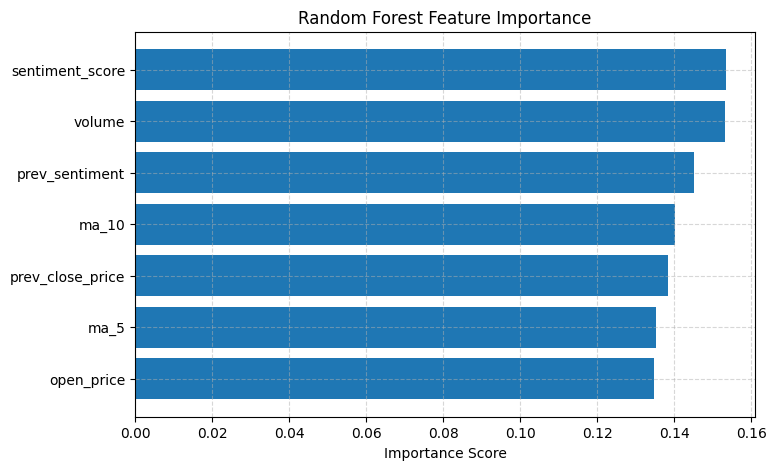

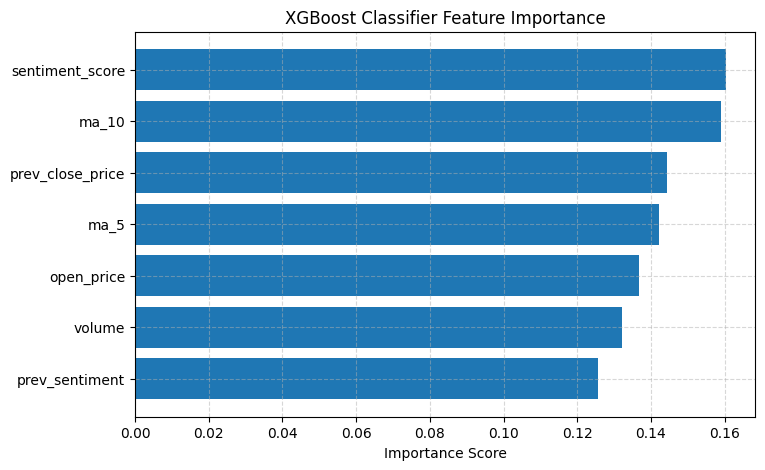

No feature importance for SVM


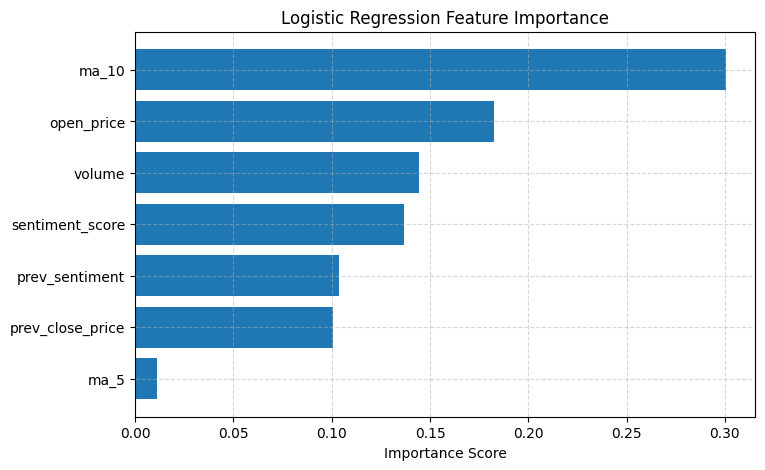

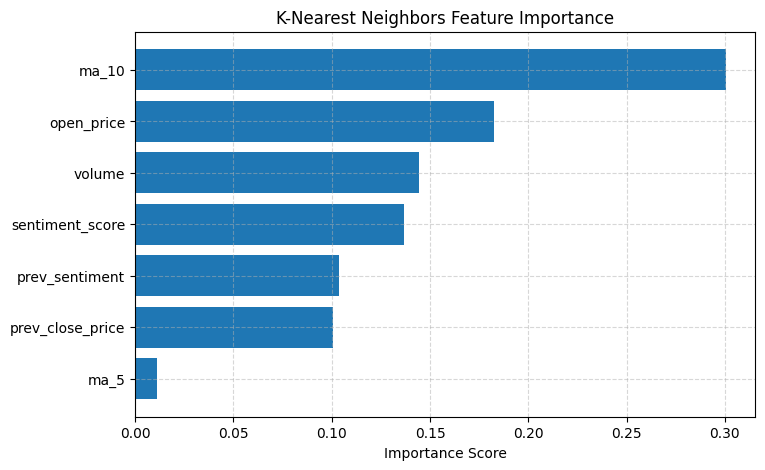

In [36]:
# Save the trained models for feature importance plotting
best_logreg = models['Logistic Regression']
best_rf = models['Random Forest']
best_xgb = models['XGBoost Classifier']
best_svm = models['Support Vector Machine']
best_knn = models['K-Nearest Neighbors']

# Generic function to plot feature importance
def plot_feature_importance(model, model_name, feature_names):
    if hasattr(model, 'feature_importances_'):
        # Tree-based models (Random Forest, XGBoost)
        importances = model.feature_importances_
    elif hasattr(model, 'coef_'):
        # Linear models (Logistic Regression, SVM if linear)
        importances = np.abs(model.coef_[0])
    else:
        print(f"No feature importance for {model_name}")
        return

    sorted_idx = np.argsort(importances)
    
    plt.figure(figsize=(8,5))
    plt.barh(range(len(sorted_idx)), importances[sorted_idx], align='center')
    plt.yticks(range(len(sorted_idx)), np.array(feature_names)[sorted_idx])
    plt.title(f"{model_name} Feature Importance")
    plt.xlabel("Importance Score")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

# Define your feature names (after adding Volume, MA5, MA10)
feature_names = ['open_price', 'sentiment_score', 'prev_sentiment', 'prev_close_price', 'ma_5', 'ma_10', 'volume']

# Example assuming your models are named like this:
# best_rf, best_xgb, best_svm, best_logreg

# Plot feature importances
plot_feature_importance(best_rf, "Random Forest", feature_names)
plot_feature_importance(best_xgb, "XGBoost Classifier", feature_names)
plot_feature_importance(best_svm, "SVM", feature_names)
plot_feature_importance(best_logreg, "Logistic Regression", feature_names)
plot_feature_importance(best_logreg, "K-Nearest Neighbors", feature_names)

## Step 5.2 Correlation

In [23]:
import seaborn as sns

# Get only the feature columns
feature_df = merged_df[feature_names]

# Pearson Correlation
pearson_corr = feature_df.corr(method='pearson')
print("\n📈 Pearson Correlation Matrix:")
print(pearson_corr)


📈 Pearson Correlation Matrix:
                  open_price  sentiment_score  prev_sentiment  \
open_price          1.000000        -0.002152       -0.011815   
sentiment_score    -0.002152         1.000000        0.099687   
prev_sentiment     -0.011815         0.099687        1.000000   
prev_close_price    0.993068        -0.010995       -0.014934   
ma_5                0.985571        -0.004947       -0.012818   
ma_10               0.961887        -0.002915       -0.005061   
volume             -0.530251        -0.002571        0.023979   

                  prev_close_price      ma_5     ma_10    volume  
open_price                0.993068  0.985571  0.961887 -0.530251  
sentiment_score          -0.010995 -0.004947 -0.002915 -0.002571  
prev_sentiment           -0.014934 -0.012818 -0.005061  0.023979  
prev_close_price          1.000000  0.989804  0.967081 -0.529308  
ma_5                      0.989804  1.000000  0.985613 -0.517635  
ma_10                     0.967081  0.985613  

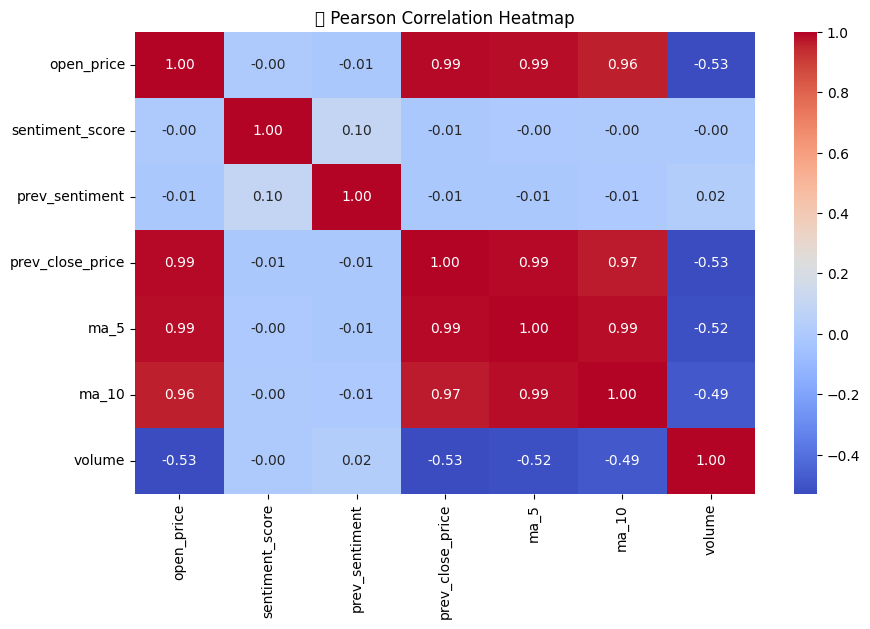

In [24]:
plt.figure(figsize=(10,6))
sns.heatmap(pearson_corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("📈 Pearson Correlation Heatmap")
plt.show()




📈 Spearman Correlation Matrix:
                  open_price  sentiment_score  prev_sentiment  \
open_price          1.000000        -0.008521       -0.013236   
sentiment_score    -0.008521         1.000000        0.179939   
prev_sentiment     -0.013236         0.179939        1.000000   
prev_close_price    0.990791        -0.007817       -0.005226   
ma_5                0.979074        -0.012841       -0.008696   
ma_10               0.948348        -0.004195        0.000893   
volume             -0.424347        -0.009988        0.009025   

                  prev_close_price      ma_5     ma_10    volume  
open_price                0.990791  0.979074  0.948348 -0.424347  
sentiment_score          -0.007817 -0.012841 -0.004195 -0.009988  
prev_sentiment           -0.005226 -0.008696  0.000893  0.009025  
prev_close_price          1.000000  0.983446  0.953501 -0.423270  
ma_5                      0.983446  1.000000  0.978092 -0.409606  
ma_10                     0.953501  0.978092 

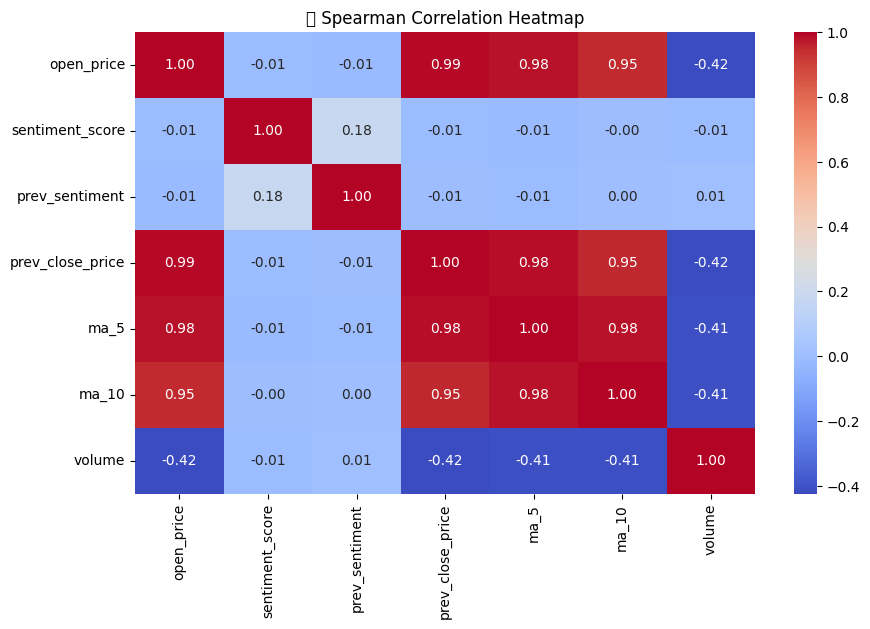

In [25]:
# Spearman Correlation
spearman_corr = feature_df.corr(method='spearman')
print("\n📈 Spearman Correlation Matrix:")
print(spearman_corr)

plt.figure(figsize=(10,6))
sns.heatmap(spearman_corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("📈 Spearman Correlation Heatmap")
plt.show()

# Step 6 Live Prediction

In [37]:

# Initialize Alpha Vantage API
ALPHA_VANTAGE_API_KEY = "75fe9a978b73483eb03e708e767eab83"
ts = TimeSeries(key=ALPHA_VANTAGE_API_KEY, output_format='pandas')

# Fetch intraday data for Tesla (TSLA)
data, meta_data = ts.get_intraday(symbol='TSLA', interval='5min', outputsize='compact')

# Latest available record
latest_data = data.iloc[-1]

open_price = latest_data['1. open']
prev_close_price = latest_data['4. close']  # Close of previous interval

print(f"Live Open Price: {open_price}")
print(f"Prev Close Price: {prev_close_price}")


Live Open Price: 281.93
Prev Close Price: 280.7101


In [29]:
latest_volume = data.iloc[-1]['5. volume']

print(f"Latest Volume: {latest_volume}")

Latest Volume: 1946672.0


In [38]:
from newsapi import NewsApiClient

# Initialize NewsAPI
NEWS_API_KEY = "75fe9a978b73483eb03e708e767eab83"
newsapi = NewsApiClient(api_key=NEWS_API_KEY)

# Fetch top headlines for Tesla
articles = newsapi.get_everything(q='Tesla', language='en', sort_by='publishedAt', page_size=5)

# Extract headlines
news_headlines = [article['title'] for article in articles['articles']]

print(news_headlines)


['Trump Says US Ships Need Free Travel Through Panama, Suez Canals', 'This Transformable Electric Truck Could Become the Cheapest EV in the US', 'At a major Hong Kong electronics exhibition, some Chinese companies say they are exploring ways to lower or skirt tariffs while others plan to wait them out', 'TikTok to enter Japan e-commerce, Nikkei reports', "Tesla is promoting 'pre-tariff' EVs in Canada as prices begin to rise"]


In [39]:
def get_finbert_sentiment(text):
    if pd.isnull(text):
        return {"label": "neutral", "score": 0.0}  # Handle missing titles safely
    prediction = finbert_pipeline(text[:512])[0]  # FinBERT models can handle 512 tokens max
    return prediction


# Predict sentiment for each headline
sentiment_results = [get_finbert_sentiment(title) for title in news_headlines]

# Convert to DataFrame if you want
sentiment_df = pd.DataFrame(sentiment_results)
sentiment_df['title'] = news_headlines

print(sentiment_df[['title', 'label']])

                                               title     label
0  Trump Says US Ships Need Free Travel Through P...   Neutral
1  This Transformable Electric Truck Could Become...  Positive
2  At a major Hong Kong electronics exhibition, s...   Neutral
3   TikTok to enter Japan e-commerce, Nikkei reports   Neutral
4  Tesla is promoting 'pre-tariff' EVs in Canada ...   Neutral


In [40]:
# Define weight for each label
label_weights = {
    "positive": 1.0,
    "neutral": 0.0,   # ignore neutral from boosting the score
    "negative": -1.0
}

# Adjusted score based on sentiment label
sentiment_df['adjusted_score'] = sentiment_df.apply(
    lambda row: row['score'] * label_weights.get(row['label'].lower(), 0),
    axis=1
)

# Calculate weighted sentiment
current_sentiment_score = sentiment_df['adjusted_score'].sum() / len(sentiment_df)

print(f"🎯 Weighted Current Sentiment Score: {current_sentiment_score:.2f}")


🎯 Weighted Current Sentiment Score: 0.20


In [55]:
live_input = pd.DataFrame({
    'open_price': [open_price],
    'sentiment_score': 0.99,
    'prev_sentiment': 0.99,
    'prev_close_price': [prev_close_price],
    'ma_5': 252.134,
    'ma_10': 250.236,
    'volume': latest_volume
})

print(live_input)



   open_price  sentiment_score  prev_sentiment  prev_close_price     ma_5  \
0      281.93             0.99            0.99          280.7101  252.134   

     ma_10     volume  
0  250.236  1946672.0  


In [56]:
rf_prediction = best_rf.predict(sample_live_input)[0]

label_map = {0: 'Down', 1: 'Stable', 2: 'Up'}
predicted_class_rf = label_map.get(rf_prediction, "Unknown")

print(f"🎯 Live Random Forest Prediction: {predicted_class_rf} (Label {rf_prediction})")


🎯 Live Random Forest Prediction: Down (Label 0)


In [57]:
import pickle


# Save the trained model to a pickle file
with open('best_rf.pkl', 'wb') as f:
    pickle.dump(best_rf, f)
